In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import datetime as dt
from itertools import product


#преобразованиe Бокса-КоксаL
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Прогнозирование уровня средней заработной платы в России

In [2]:
pay = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
pay.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## Визуальный анализ ряда

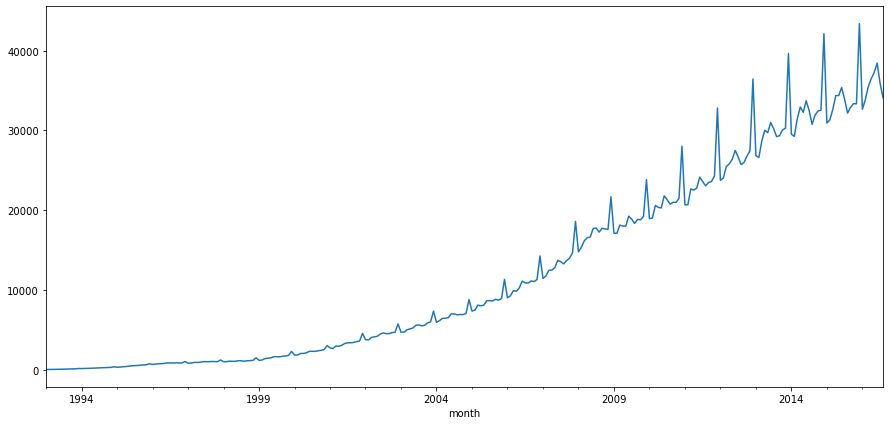

In [3]:
plt.figure(figsize(15,7))
pay.WAG_C_M.plot()
plt.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

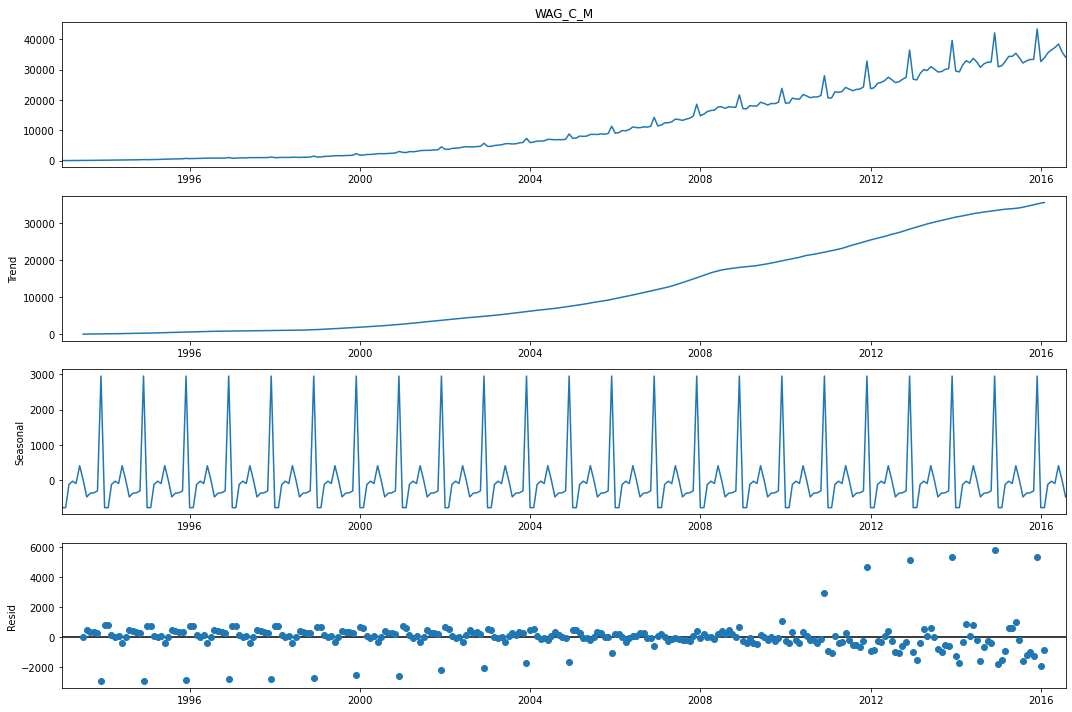

In [4]:
plt.figure(figsize(15,10))

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(pay.WAG_C_M)[1])

sm.tsa.seasonal_decompose(pay.WAG_C_M).plot()
plt.show()

Ряд нестационарен, выражена сезонность, дисперсия изменяется

##  Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202


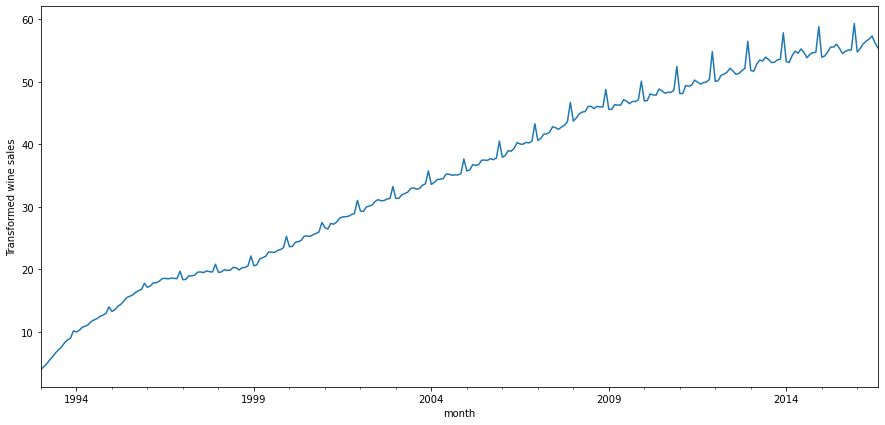

In [5]:
pay['WAG'], lmbda = stats.boxcox(pay.WAG_C_M)
plt.figure(figsize(15,7))
pay.WAG.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

## Выбор порядка дифференцирования

Ряд имеет явно выраженные тренд, попробуем произвести сезонное дифференциирование

Критерий Дики-Фуллера: p=0.014697


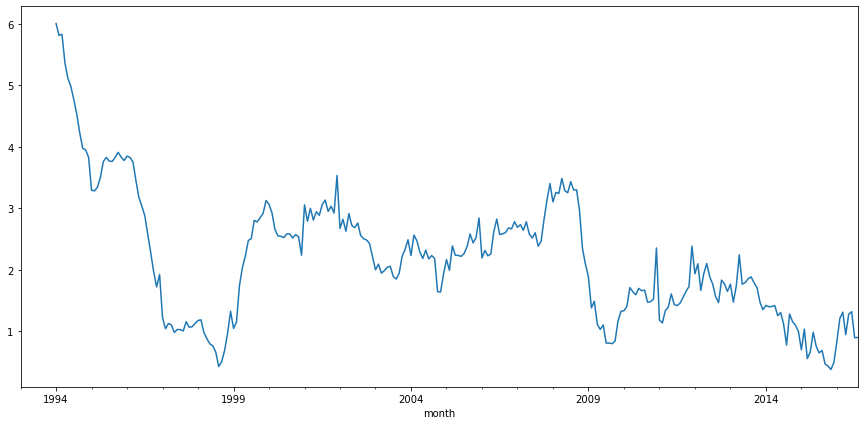

In [6]:
pay['WAG_d12'] = pay.WAG - pay.WAG.shift(12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(pay.WAG_d12.dropna())[1])
pay.WAG_d12.plot()
plt.show()

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

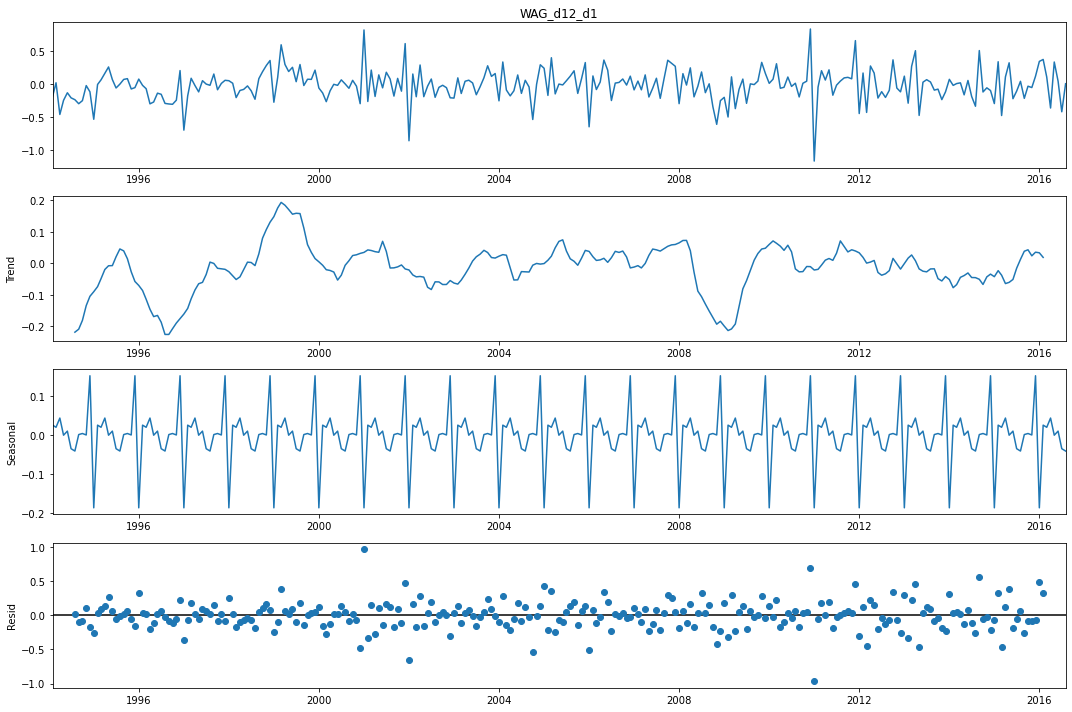

In [7]:
pay['WAG_d12_d1'] = pay.WAG_d12 - pay.WAG_d12.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(pay.WAG_d12_d1[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(pay.WAG_d12_d1[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Выбор начальных приближений для p, q, P, Q

<Figure size 1080x288 with 0 Axes>

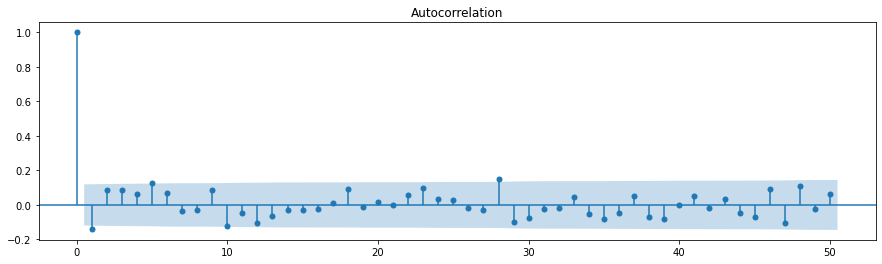

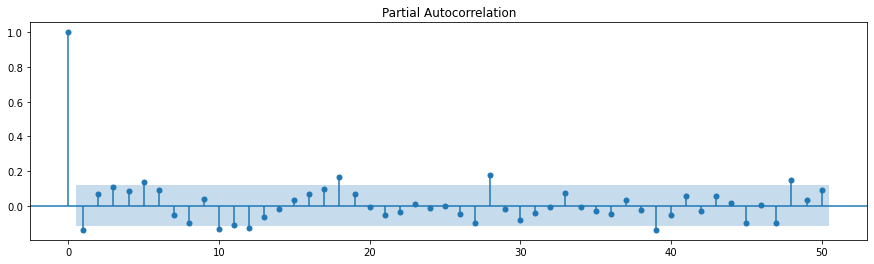

In [8]:
plt.figure(figsize(15,4))
sm.graphics.tsa.plot_acf(pay.WAG_d12_d1.dropna().values.squeeze(), lags=50)

sm.graphics.tsa.plot_pacf(pay.WAG_d12_d1.dropna().values.squeeze(), lags=50)

plt.show()

В рассматриваемом ряде сезонных лагов со значимой корреляцией нет, значит, начальное приближение Q = 0.
q = 5.
P = 4.
p = 5.

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [9]:
D=1
d=1

Qs = range(0,1)
qs = range(0, 6)
Ps = range(0, 5)
ps = range(0, 4) 
#ps = range(0, >4)  - ошибка LU decomposition error

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(pay.WAG, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 5min 56s


In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
70   (2, 2, 0, 0) -21.488595
71   (2, 2, 1, 0) -21.473461
75   (2, 3, 0, 0) -21.091475
76   (2, 3, 1, 0) -20.398612
101  (3, 2, 1, 0) -20.378973


In [32]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 WAG   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Mon, 26 Jul 2021   AIC                            -21.489
Time:                                     08:53:15   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.951      0.000       1.400       1.571
ar.L2         -0.6838      

## Анализ остатков построенной модели

Критерий Стьюдента: p=0.269833
Критерий Дики-Фуллера: p=0.000000


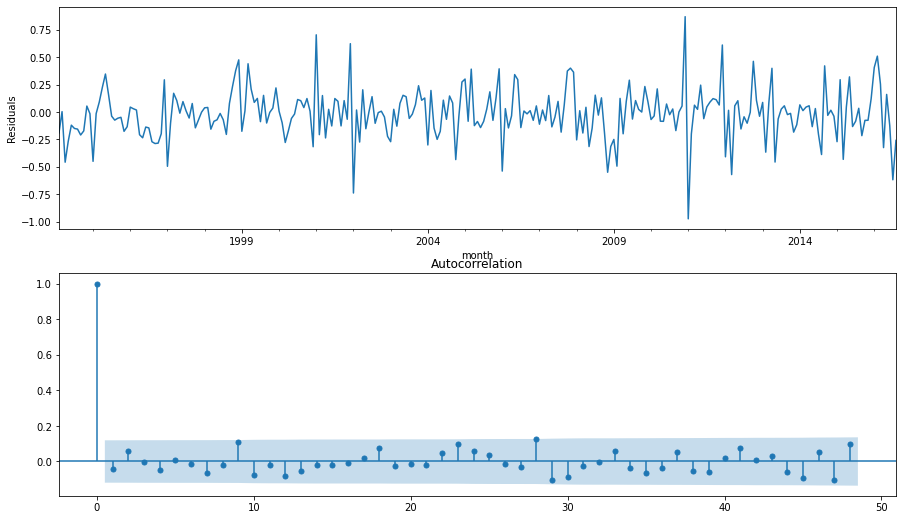

In [33]:
plt.figure(figsize(15,9))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

C:\Users\tskhay_da\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


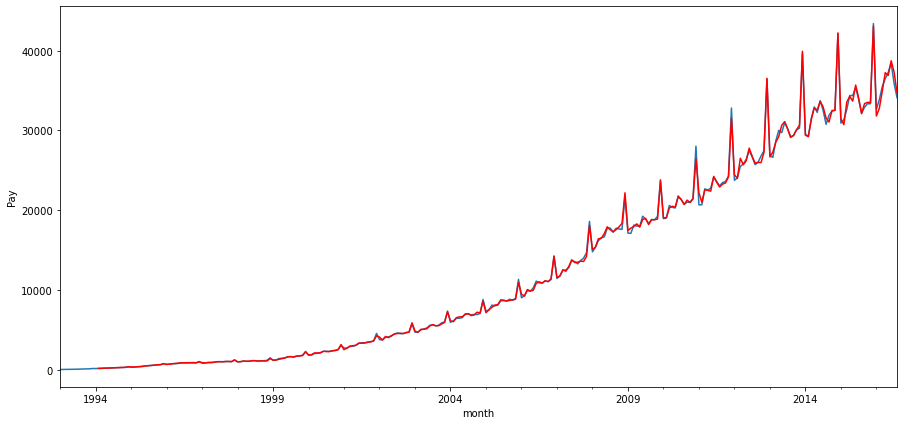

In [34]:
pay['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
pay.WAG_C_M.plot()
pay.model[13:].plot(color='r')
plt.ylabel('Pay')
pylab.show()

## Прогнозирование с помощью финальной модели.

In [35]:
pay.WAG_C_M

C:\Users\tskhay_da\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


month
1993-01-01       15.3
1993-02-01       19.1
1993-03-01       23.6
1993-04-01       30.6
1993-05-01       37.5
               ...   
2016-04-01    36497.0
2016-05-01    37270.0
2016-06-01    38447.0
2016-07-01    35888.0
2016-08-01    34095.0
Name: WAG_C_M, Length: 284, dtype: float64

C:\Users\tskhay_da\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


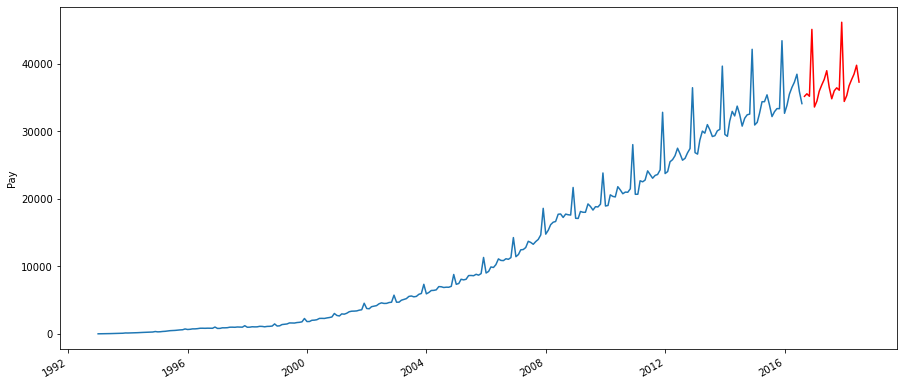

In [41]:
pay2 = pay[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= pay2.columns)
pay2 = pd.concat([pay2, future])
pay2['forecast'] = invboxcox(best_model.predict(start=284, end=284+24), lmbda)

plt.figure(figsize(15,7))
pay2.WAG_C_M.plot()
pay2.forecast.plot(color='r')
plt.ylabel('Pay')
pylab.show()